#CMPT353 summer 2020
#SFU
#Course Project
#Author: Wei Yao (yaoweiy@sfu.ca) Yiran Zhang(yza363@sfu.ca)
#Dataset 1: Covid-19
#Resource Ref: https://www.kaggle.com/kimjihoo/coronavirusdataset
#Dataset 2: COVID19 Global Forecasting
#Resource Ref: https://www.kaggle.com/c/covid19-global-forecasting-week-5

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import plotly.express as px
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn import tree, metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, train_test_split

# 1. Cases vs Time

In [247]:
time_count = pd.read_csv('Time.csv')

In [248]:
time_count.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


In [249]:
time_count.shape


(163, 7)

In [250]:
#drop null if any and delete the unnecessary column ['time']
time_count.dropna()
time_count.drop(columns=['time'], inplace=True)
time_count

,date,test,negative,confirmed,released,deceased
0,2020-01-20,1,0,1,0,0
1,2020-01-21,1,0,1,0,0
2,2020-01-22,4,3,1,0,0
3,2020-01-23,22,21,1,0,0
4,2020-01-24,27,25,2,0,0
...,...,...,...,...,...,...
158,2020-06-26,1232315,1200885,12602,11172,282
159,2020-06-27,1243780,1211261,12653,11317,282
160,2020-06-28,1251695,1219975,12715,11364,282
161,2020-06-29,1259954,1228698,12757,11429,282


## 1.1. Total Cases vs Confirmed

         date  test  negative  confirmed  released  deceased
0  2020-01-20     1         0          1         0         0
1  2020-01-21     1         0          1         0         0
2  2020-01-22     4         3          1         0         0
3  2020-01-23    22        21          1         0         0
4  2020-01-24    27        25          2         0         0


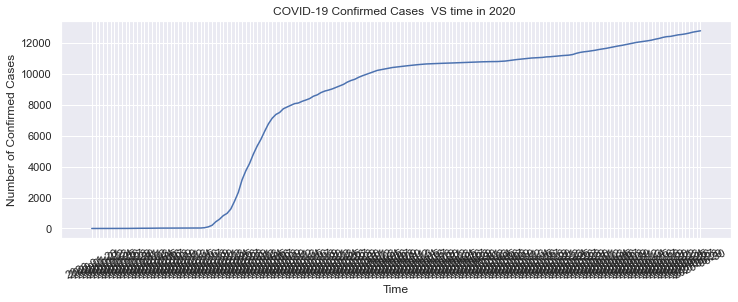

In [251]:
print(time_count.head())
plt.figure(figsize=(12, 4))
plt.xticks(rotation=25)
plt.title('COVID-19 Confirmed Cases  VS time in 2020 ')
plt.xlabel('Time')
plt.ylabel('Number of Confirmed Cases')
plt.plot(time_count['date'],time_count['confirmed'])
plt.show()

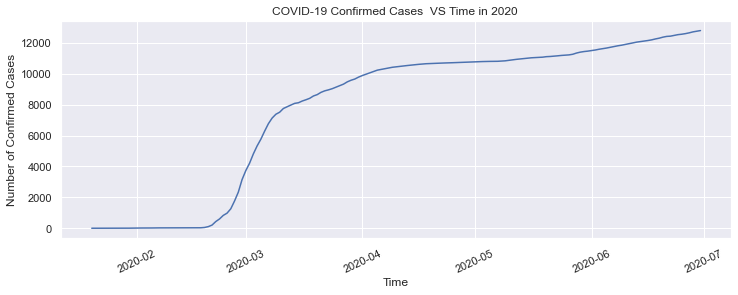

In [252]:
# The x-axis looks wried, so I tried to modify the data timestamp to give a clear view again
seaborn.set()
time_count['date']=pd.to_datetime(time_count['date'],format = '%Y-%m-%d')

plt.figure(figsize=(12, 4))
plt.xticks(rotation=25)
plt.title('COVID-19 Confirmed Cases  VS Time in 2020 ')
plt.xlabel('Time')
plt.ylabel('Number of Confirmed Cases')
plt.plot(time_count['date'],time_count['confirmed'])
plt.show()

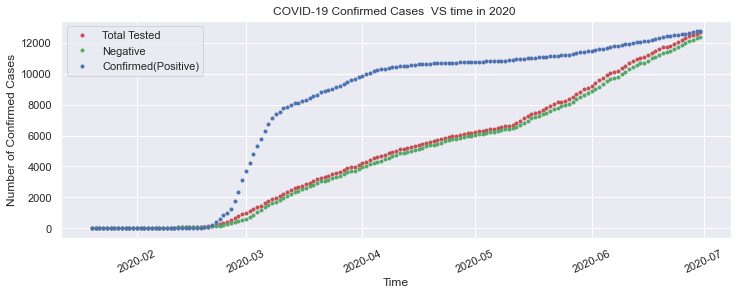

In [253]:
# Add more details into the cases ( negative and total tested cases)
time_count['percentage'] =time_count['confirmed'] / time_count['test']
plt.figure(figsize=(12, 4))
plt.xticks(rotation=25)
plt.title('COVID-19 Confirmed Cases  VS time in 2020 ')
plt.xlabel('Time')
plt.ylabel('Number of Confirmed Cases')
plt.plot(time_count['date'],time_count['test']/100,'r.')
plt.plot(time_count['date'],time_count['negative']/100,'g.')
plt.plot(time_count['date'],time_count['confirmed'],'b.')
plt.legend(['Total Tested','Negative','Confirmed(Positive)'])
plt.show()

## 1.2. Percentage Ratio of Confirmed Cases Trends

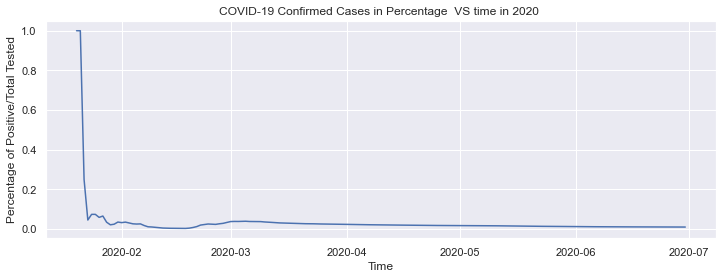

In [254]:
#print(time_count)
plt.figure(figsize=(12, 4))
plt.title('COVID-19 Confirmed Cases in Percentage  VS time in 2020 ')
plt.xlabel('Time')
plt.ylabel('Percentage of Positive/Total Tested')
plt.plot(time_count['date'],time_count['percentage'])
plt.show()

## 1.3. Comparison of New Cases

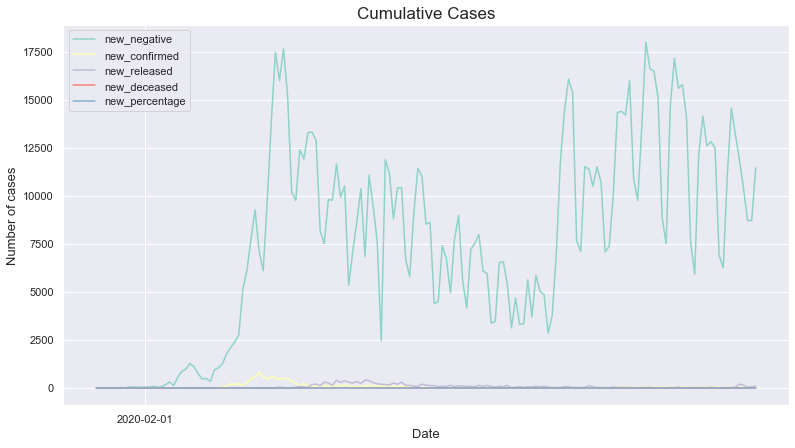

In [255]:
color_list = ['#8DD3C7', '#FEFFB3', '#BFBBD9'
              , '#FA8174', '#81B1D2', '#FDB462'
              , '#B3DE69', '#BC82BD', '#CCEBC4']

def plot_lines(data, column_list, column_max, title):
    """
    FUNCTION
        to show many plots with combinations of lines with consistent colors and legend
        useful for plotting lines with different scales at once and then separately

    RETURN
        None
    """
    for i in column_list:
        fig, ax = plt.subplots(figsize=(13, 7))
        plt.title(f'{title}', fontsize=17)
        color_group = color_list[:-4][-(column_max-i):]
        for test_each, color_each in zip(data.columns[i:column_max], color_group):
            plt.plot(data.date, data[test_each]
                     , label=test_each, color=color_each
                    )
            label=data[test_each]
        ax.set_xticks(ax.get_xticks()[::int(len(data.date)/8)])
        plt.xlabel('Date', size=13)
        plt.ylabel('Number of cases', size=13)
        ax.legend(loc='upper left')
        plt.show()


for col in time_count.columns[2:7]:
    if col in [2, 4]:
        new_dict = {0: 1}
    else:
        new_dict = {0: 0}
    new_dict.update({ i : time_count[col][i] - time_count[col][i-1] for i in range(1, len(time_count)) })
    time_count[f'new_{col}'] = new_dict.values()

plot_lines(time_count, [7],12, 'Cumulative Cases')

# 2. Case vs Age

In [256]:
data = pd.read_csv('PatientInfo.csv')

In [257]:
data.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [258]:
data.shape

(5165, 14)

In [259]:
# clean data: drop null if any and select necessary column ['sex','age']
data = data[data['country'] == 'Korea']
data = data[['sex', 'age']]
data = data.dropna().reset_index(drop=True)
data

,sex,age
0,male,50s
1,male,30s
2,male,50s
3,male,20s
4,female,20s
...,...,...
3739,female,20s
3740,male,30s
3741,female,20s
3742,female,30s


## 2.1. Male and Female Case vs Age

In [260]:
age_count = pd.DataFrame(data['age'].value_counts())
age_count.reset_index(level=0, inplace = True)
age_count.columns = ['age', 'counts']
age_count

,age,counts
0,20s,885
1,50s,665
2,40s,512
3,30s,510
4,60s,479
5,70s,231
6,10s,177
7,80s,170
8,0s,65
9,90s,49


In [261]:
def str_to_int(age):
    for i in range(0,age.shape[0]):
        age[i] = int(age[i][:-1])

In [262]:
# set age as int
str_to_int(age_count['age'])

<ipython-input-261-604283338679>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [263]:
# sort age from 0 to 100
age_count = age_count.sort_values('age')
age_count

,age,counts
8,0,65
6,10,177
0,20,885
3,30,510
2,40,512
1,50,665
4,60,479
5,70,231
7,80,170
9,90,49


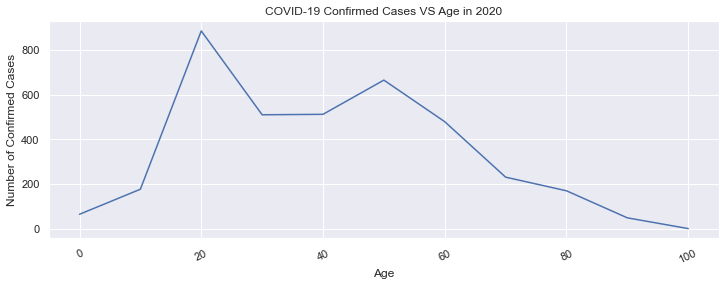

In [264]:
plt.figure(figsize=(12, 4))
plt.xticks(rotation=25)
plt.title('COVID-19 Confirmed Cases VS Age in 2020')
plt.xlabel('Age')
plt.ylabel('Number of Confirmed Cases')
plt.plot(age_count['age'],age_count['counts'])
plt.show()

## 2.2. Male Case vs Age

In [265]:
male_data = data[data['sex'] == 'male']
male_age_count = pd.DataFrame(male_data['age'].value_counts())
male_age_count.reset_index(level=0, inplace = True)
male_age_count.columns = ['age', 'counts']
male_age_count

,age,counts
0,20s,431
1,30s,273
2,50s,262
3,60s,211
4,40s,206
5,10s,110
6,70s,88
7,80s,56
8,0s,37
9,90s,16


In [266]:
# set age as int
str_to_int(male_age_count['age'])
# sort age from 0 to 90
male_age_count = male_age_count.sort_values('age')
male_age_count

<ipython-input-261-604283338679>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,age,counts
8,0,37
5,10,110
0,20,431
1,30,273
4,40,206
2,50,262
3,60,211
6,70,88
7,80,56
9,90,16


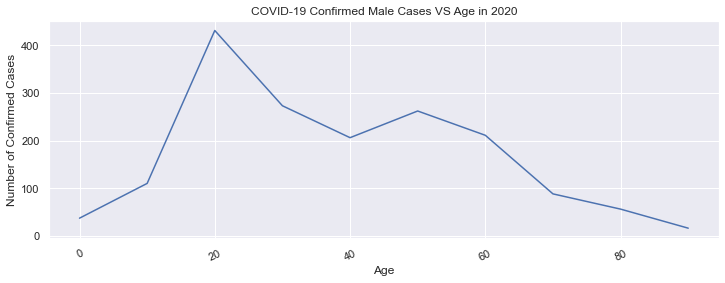

In [267]:
plt.figure(figsize=(12, 4))
plt.xticks(rotation=25)
plt.title('COVID-19 Confirmed Male Cases VS Age in 2020')
plt.xlabel('Age')
plt.ylabel('Number of Confirmed Cases')
plt.plot(male_age_count['age'],male_age_count['counts'])
plt.show()

## 2.3. Female Case vs Age

In [268]:
female_data = data[data['sex'] == 'female']
female_age_count = pd.DataFrame(female_data['age'].value_counts())
female_age_count.reset_index(level=0, inplace = True)
female_age_count.columns = ['age', 'counts']
female_age_count

,age,counts
0,20s,454
1,50s,403
2,40s,306
3,60s,268
4,30s,237
5,70s,143
6,80s,114
7,10s,67
8,90s,33
9,0s,28


In [269]:
# set age as int
str_to_int(female_age_count['age'])
# sort age from 0 to 100
female_age_count = female_age_count.sort_values('age')
female_age_count

<ipython-input-261-604283338679>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,age,counts
9,0,28
7,10,67
0,20,454
4,30,237
2,40,306
1,50,403
3,60,268
5,70,143
6,80,114
8,90,33


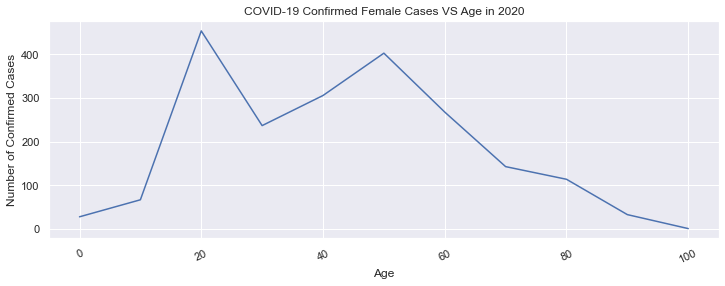

In [270]:
plt.figure(figsize=(12, 4))
plt.xticks(rotation=25)
plt.title('COVID-19 Confirmed Female Cases VS Age in 2020')
plt.xlabel('Age')
plt.ylabel('Number of Confirmed Cases')
plt.plot(female_age_count['age'],female_age_count['counts'])
plt.show()

## 2.4. Merge Into One Diagram

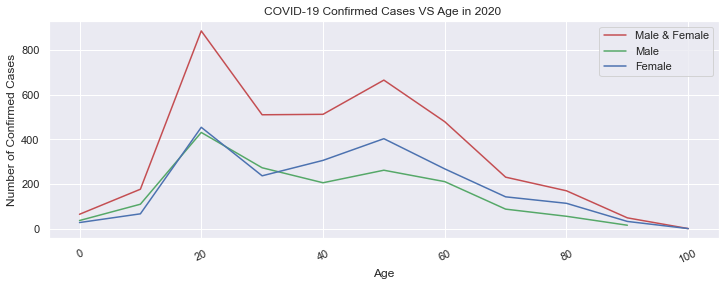

In [271]:
plt.figure(figsize=(12, 4))
plt.xticks(rotation=25)
plt.title('COVID-19 Confirmed Cases VS Age in 2020 ')
plt.xlabel('Age')
plt.ylabel('Number of Confirmed Cases')
plt.plot(age_count['age'],age_count['counts'],'r')
plt.plot(male_age_count['age'],male_age_count['counts'],'g')
plt.plot(female_age_count['age'],female_age_count['counts'],'b')
plt.legend(['Male & Female','Male','Female'])
plt.show()

## 2.5. The Proportion of Patients of All Ages was Compared

In [272]:
# sum the number of cases for three diff ways
mf_case = age_count['counts'].sum()
m_case = male_age_count['counts'].sum()
f_case = female_age_count['counts'].sum()

In [273]:
# both male and female
age_count['proportion'] = (age_count['counts'] / mf_case) * 100
age_count['proportion'] = age_count['proportion'].round(decimals=2)
# male
male_age_count['proportion'] = (age_count['counts'] / mf_case) * 100
male_age_count['proportion'] = age_count['proportion'].round(decimals=2)
# female
female_age_count['proportion'] = (age_count['counts'] / mf_case) * 100
female_age_count['proportion'] = age_count['proportion'].round(decimals=2)

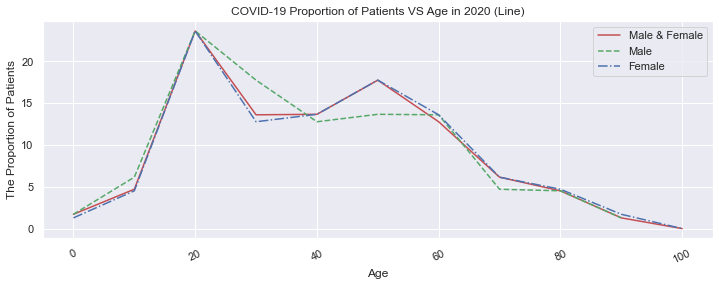

In [274]:
plt.figure(figsize=(12, 4))
plt.xticks(rotation=25)
plt.title('COVID-19 Proportion of Patients VS Age in 2020 (Line)')
plt.xlabel('Age')
plt.ylabel('The Proportion of Patients')
plt.plot(age_count['age'],age_count['proportion'],'r')
plt.plot(male_age_count['age'],male_age_count['proportion'],'g--')
plt.plot(female_age_count['age'],female_age_count['proportion'],'b-.')
plt.legend(['Male & Female','Male','Female'])
plt.show()

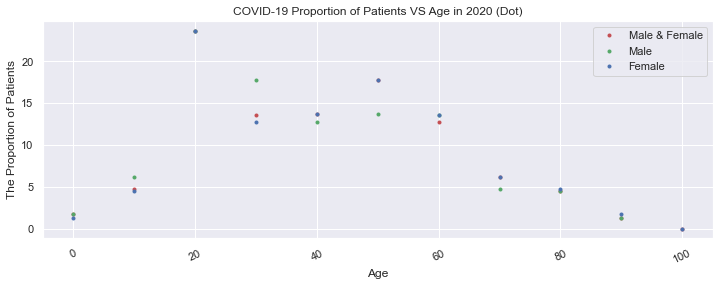

In [275]:
plt.figure(figsize=(12, 4))
plt.xticks(rotation=25)
plt.title('COVID-19 Proportion of Patients VS Age in 2020 (Dot)')
plt.xlabel('Age')
plt.ylabel('The Proportion of Patients')
plt.plot(age_count['age'],age_count['proportion'],'r.')
plt.plot(male_age_count['age'],male_age_count['proportion'],'g.')
plt.plot(female_age_count['age'],female_age_count['proportion'],'b.')
plt.legend(['Male & Female','Male','Female'])
plt.show()

# 3. Case vs City

In [323]:
data = pd.read_csv('PatientInfo.csv')
data.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [324]:
data.shape

(5165, 14)

In [325]:
# clean data: drop null if any and select necessary column ['sex','age']
data = data[data['country'] == 'Korea']
data = data[['province','city']]
data = data.dropna().reset_index(drop=True)
data

,province,city
0,Seoul,Gangseo-gu
1,Seoul,Jungnang-gu
2,Seoul,Jongno-gu
3,Seoul,Mapo-gu
4,Seoul,Seongbuk-gu
...,...,...
5025,Jeju-do,Jeju-do
5026,Jeju-do,Jeju-do
5027,Jeju-do,Jeju-do
5028,Jeju-do,Jeju-do


## 3.1. Cases vs Province

In [326]:
province_count = pd.DataFrame(data['province'].value_counts())
province_count.reset_index(level=0, inplace=True)
province_count.columns = ['province', 'counts']
province_count

,province,counts
0,Seoul,1302
1,Gyeongsangbuk-do,1252
2,Gyeonggi-do,1203
3,Incheon,338
4,Chungcheongnam-do,166
5,Busan,145
6,Gyeongsangnam-do,130
7,Daejeon,119
8,Daegu,89
9,Gangwon-do,61


In [327]:
fig = px.pie(province_count, values='counts', names='province')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

## 3.2 Cases vs City

In [328]:
city_count = pd.DataFrame(data['city'].value_counts())
city_count.reset_index(level=0, inplace = True)
city_count.columns = ['city', 'counts']
city_count

,city,counts
0,Gyeongsan-si,639
1,Seongnam-si,173
2,Bucheon-si,161
3,Gwanak-gu,112
4,Cheonan-si,110
...,...,...
157,Okcheon-gun,1
158,Dalseong-gun,1
159,Inje-gun,1
160,Hoengseong-gun,1


In [329]:
fig = px.pie(city_count, values='counts', names='city')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

## 3.3 Merge City and Province

In [330]:
city_province = data.drop_duplicates(subset='city',keep='first', inplace=False).reset_index(drop=True)
city_province = city_province[['province','city']]
city_province

,province,city
0,Seoul,Gangseo-gu
1,Seoul,Jungnang-gu
2,Seoul,Jongno-gu
3,Seoul,Mapo-gu
4,Seoul,Seongbuk-gu
...,...,...
157,Gyeongsangnam-do,Miryang-si
158,Gyeongsangnam-do,Haman-gun
159,Gyeongsangnam-do,Sancheong-gun
160,Gyeongsangnam-do,Sacheon-si


In [331]:
# Merge the two dfs based on city column
city_count.set_index(['city'], inplace=True)
result = city_province.join(city_count,on='city')
result

,province,city,counts
0,Seoul,Gangseo-gu,82
1,Seoul,Jungnang-gu,32
2,Seoul,Jongno-gu,19
3,Seoul,Mapo-gu,38
4,Seoul,Seongbuk-gu,33
...,...,...,...
157,Gyeongsangnam-do,Miryang-si,5
158,Gyeongsangnam-do,Haman-gun,1
159,Gyeongsangnam-do,Sancheong-gun,1
160,Gyeongsangnam-do,Sacheon-si,3


In [332]:
fig = px.treemap(result, path=['province','city'], values='counts',
                  color='counts', hover_data=['city'],
                  color_continuous_scale='matter', title='Current COVID19 Confirmed Cases In South Korea')
fig.show()


# 4. Prediction Model

In [349]:
#load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

C:\Users\grant\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



In [350]:
#get the name of 'south korean'
country =train_data.Country_Region.unique()
print(country)

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Comoros' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' 'Denmark' 'Diamond Princess' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Holy See'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jo

In [351]:
# filter to extract korean data
train_data=train_data[train_data['Country_Region']=='Korea, South']

# check head and drop unuseful columns
train=train_data.drop(['Id','County','Province_State','Country_Region'],axis=1)

# convert the target value to integer, confirmedCases to 1, Fatalities to 0
train['Target'].replace({'ConfirmedCases':1, 'Fatalities':0}, inplace=True)

train.head()

,Population,Weight,Date,Target,TargetValue
43680,25281000,0.058666,2020-01-23,1,0
43681,25281000,0.586663,2020-01-23,0,0
43682,25281000,0.058666,2020-01-24,1,1
43683,25281000,0.586663,2020-01-24,0,0
43684,25281000,0.058666,2020-01-25,1,0


In [352]:
# filter to extract korean data
test_data=test_data[test_data['Country_Region']=='Korea, South']

# check head and drop unuseful columns
test=test_data.drop(['ForecastId','County','Province_State','Country_Region'],axis=1)

# convert the target value to integer, confirmedCases to 1, Fatalities to 0
test['Target'].replace({'ConfirmedCases':1, 'Fatalities':0}, inplace=True)

test

,Population,Weight,Date,Target
14040,25281000,0.058666,2020-04-27,1
14041,25281000,0.586663,2020-04-27,0
14042,25281000,0.058666,2020-04-28,1
14043,25281000,0.586663,2020-04-28,0
14044,25281000,0.058666,2020-04-29,1
...,...,...,...,...
14125,25281000,0.586663,2020-06-08,0
14126,25281000,0.058666,2020-06-09,1
14127,25281000,0.586663,2020-06-09,0
14128,25281000,0.058666,2020-06-10,1


In [353]:
# create useful features for data mining tools to increase performance
# By transforming 'Date' into single values such as 'day' 'dayofweek' 'month'...
train['Date']=pd.to_datetime(train['Date'],format = '%Y-%m-%d')
train['day']=train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['quarter'] = train['Date'].dt.quarter
train['dayofweek'] = train['Date'].dt.dayofweek
train['dayofyear'] = train['Date'].dt.dayofyear
train['weekofyear'] = train['Date'].dt.weekofyear
train=train.drop(['Date'],axis=1)
X=train.drop(['TargetValue'],axis=1)
y=train['TargetValue']
X.head()

,Population,Weight,Target,day,month,quarter,dayofweek,dayofyear,weekofyear
43680,25281000,0.058666,1,23,1,1,3,23,4
43681,25281000,0.586663,0,23,1,1,3,23,4
43682,25281000,0.058666,1,24,1,1,4,24,4
43683,25281000,0.586663,0,24,1,1,4,24,4
43684,25281000,0.058666,1,25,1,1,5,25,4


In [354]:
# modify the features of test data also
# perform the predict model with good score
test['Date']=pd.to_datetime(test['Date'],format = '%Y-%m-%d')
test['day']=test['Date'].dt.day
test['month'] = test['Date'].dt.month
test['quarter'] = test['Date'].dt.quarter
test['dayofweek'] = test['Date'].dt.dayofweek
test['dayofyear'] = test['Date'].dt.dayofyear
test['weekofyear'] = test['Date'].dt.weekofyear
test=test.drop(['Date'],axis=1)
test.head()

,Population,Weight,Target,day,month,quarter,dayofweek,dayofyear,weekofyear
14040,25281000,0.058666,1,27,4,2,0,118,18
14041,25281000,0.586663,0,27,4,2,0,118,18
14042,25281000,0.058666,1,28,4,2,1,119,18
14043,25281000,0.586663,0,28,4,2,1,119,18
14044,25281000,0.058666,1,29,4,2,2,120,18


## 4.1. The Model is Established and the Predicted Value is Output

In [355]:
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.23)

In [356]:
# gradient_model = make_pipeline(
#     GradientBoostingClassifier(n_estimators =70,max_depth=3, min_samples_leaf =1)
# )
# random_f_model = make_pipeline(
#     RandomForestClassifier(n_estimators =200,max_depth =9, min_samples_leaf=40)
# )
# neural_net_model = make_pipeline(
#     MLPClassifier(solver ='lbfgs',hidden_layer_sizes=(11,11),activation ='logistic')
# )
#
# knn_model = make_pipeline(
#         KNeighborsClassifier(n_neighbors=10)
# )
#
# models = [gradient_model,random_f_model,neural_net_model,knn_model]
#
# for i, m in enumerate(models):
#     m.fit(X_train, y_train)
#     print(metrics.accuracy_score(y_test, m.predict(X_test)))

0.15384615384615385
0.2153846153846154
0.2153846153846154
0.27692307692307694


In [294]:
# knn_model = make_pipeline(
#         KNeighborsClassifier(n_neighbors=10)
# )
# knn_model.fit(X_train, y_train)
# predictions = knn_model.predict(test)
# pd.Series(predictions).to_csv('output.txt', index=False, header=False)

## 4.2. Conduct k-fold Validation and Report Precision. Recall and Accuracy for Each Validation

In [357]:
#split data
kf =KFold(n_splits =10)

#create pipeline
dt_model = make_pipeline(
    tree.DecisionTreeClassifier()
)

#train model
#dt_model.fit(X_train,y_train)
iteration = 1
macro_precision =0
macro_recall =0
for train_index, test_index in kf.split(X):
    #split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #train data
    dt_model.fit(X_train,y_train)
    y_predicted = dt_model.predict(X_test)
    print('Iteration #',iteration,':')
    iteration += 1
    print(classification_report(y_test,y_predicted))
    report = classification_report(y_test,y_predicted,output_dict=True)
    macro_precision += report['macro avg']['precision']
    macro_recall += report['macro avg']['recall']

    # print scores to check overfiting
    print('*******************')

Iteration # 1 :
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        20
           1       0.25      0.40      0.31         5
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1

    accuracy                           0.57        28
   macro avg       0.21      0.18      0.19        28
weighted avg       0.76      0.57      0.64        28

*******************
Iteration # 2 :
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        20
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
          73       0.00      0.00      0.00         0

    accuracy             

C:\Users\grant\anaconda3\envs\cmpt353finalproject\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\grant\anaconda3\envs\cmpt353finalproject\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\grant\anaconda3\envs\cmpt353finalproject\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\grant\anaconda3\envs\cmpt353finalproject\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Recall and F-